<details>
<summary>📓 &nbsp; Modeling Sequential Data Using Recurrent Neural Networks
</summary><br/>Github Links<br/>    
<a href="https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch16/ch16_part1.ipynb">Part 1</a><br/>
<a href="https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch16/ch16_part2.ipynb">Part 2</a><br/>
</details>

In [2]:
from IPython.display import display,HTML
c1,c2,f1,f2,fs1,fs2=\
'#11ff66','#6611ff','Akronim','Smokum',30,20
def dhtml(string,fontcolor=c1,font=f1,fontsize=fs1):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family="""\
    +font+"""&effect=3d-float';</style>
    <h1 class='font-effect-3d-float' style='font-family:"""+\
    font+"""; color:"""+fontcolor+"""; font-size:"""+\
    str(fontsize)+"""px;'>%s</h1>"""%string))

In [3]:
dhtml('Code Modules, Setting, & Functions')

In [4]:
import numpy as np,pylab as pl
import tensorflow as tf
import tensorflow.keras.layers as tkl
import tensorflow_datasets as tfds
from collections import Counter
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing \
import sequence as tksequence

In [5]:
def get_weights_shape(layer):
    w_xh,w_oo,b_h=layer.weights
    print('w_xh shape: %s'%w_xh.shape)
    print('w_oo shape: %s'%w_oo.shape)
    print('b_h shape: %s'%b_h.shape)    

In [6]:
def compare_calc(layer,x):
    n,inputs=x.shape[0],x.shape[1]
    w_xh,w_oo,b_h=layer.weights
    out_calc=[]
    output=layer(
        tf.reshape(x,shape=(1,n,inputs)))
    pl.figure(figsize=(10,5))
    for t in range(n):
        xt=tf.reshape(x_seq[t],(1,inputs))
        print('time step {} =>'.format(t))
        print(5*' '+'input'+13*' '+': '+
              str(xt.numpy()))
        ht=tf.matmul(xt,w_xh)+b_h 
        print(5*' '+'hidden'+11*' '+': '+   
              str(ht.numpy()))   
        if t>0:
            prev_o=out_calc[t-1]
        else:
            prev_o=tf.zeros(shape=(ht.shape))        
        ot=ht+tf.matmul(prev_o,w_oo)
        ot=tf.math.tanh(ot)
        out_calc.append(ot)
        print(5*' '+'calculated output: '+
              str(ot.numpy()))
        print(5*' '+'SimpleRNN output:   '.format(t)+
              str(output[0][t].numpy())+'\n')
        pl.plot(output[0][t].numpy(),'-o',
                label='time step %d'%t)
    pl.grid(); pl.legend(); pl.show()

In [7]:
dhtml('Data Exploration')

In [8]:
# 25,000 movies reviews from IMDB, 
# labeled by sentiment (positive/negative)
num_words=10000; max_length=1000
embedding_vector_length=32
(x_train,y_train),(x_test,y_test)=\
imdb.load_data(path="imdb_full.pkl",
               num_words=num_words,
               skip_top=0,seed=113,
               maxlen=max_length,
               start_char=1,oov_char=2,
               index_from=3)
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(24875,) (24944,)
(24875,) (24944,)


In [9]:
x=np.vstack([x_train.reshape(-1,1),
             x_test.reshape(-1,1)])
y=np.vstack([y_train.reshape(-1,1),
             y_test.reshape(-1,1)])
x=x.reshape(-1); y=y.reshape(-1)
x.shape,y.shape

((49819,), (49819,))

In [10]:
word_to_id=imdb.get_word_index()
word_to_id=\
{k:(v+3) for k,v in word_to_id.items()}
sw=["<PAD>","<START>","<UNK>","<UNUSED>"]
for i in range(4): word_to_id[sw[i]]=i
id_to_word=\
 {value:key for key,value in word_to_id.items()}
def get_string(x,i):
    return ' '.join(id_to_word[id] for id in x[i] if id>3)

In [11]:
features=[get_string(x,i) 
          for i in range(x.shape[0])]
features=np.array(features)
targets=y
dhtml(features[0],c2,f2,fs2)

In [12]:
dhtml('Data Building')

In [13]:
ds=tf.data.Dataset\
.from_tensor_slices((features,targets))
for ex in ds.take(3):
    tf.print(ex[0].numpy()[:50],ex[1])

b'this film was just brilliant casting location scen' 1
b'big hair big boobs bad music and a giant safety pi' 0
b'this has to be one of the worst films of the 1990s' 0


In [14]:
tf.random.set_seed(123)
ds=ds.shuffle(50000,reshuffle_each_iteration=False)
ds_test=ds.take(10000)
ds_train_valid=ds.skip(10000)
ds_valid=ds_train_valid.take(10000)
ds_train=ds_train_valid.skip(10000)

In [15]:
tokenizer=tfds.features.text.Tokenizer()
token_counts=Counter()
for example in ds_train:
    tokens=tokenizer.tokenize(example[0].numpy())
    token_counts.update(tokens)
print('vocabulary size:',len(token_counts))

vocabulary size: 9807


In [16]:
encoder=tfds.features.text\
.TokenTextEncoder(token_counts)
example_str='hi this is an example of sentences'
encoder.encode(example_str)

[4621, 4, 12, 97, 121, 22, 4029]

In [17]:
def encode(text_tensor,label):
    text=text_tensor.numpy()
    encoded_text=encoder.encode(text)
    return encoded_text,label
def encode_fmap(text,label):
    return tf.py_function(encode,inp=[text,label], 
                          Tout=(tf.int64,tf.int64))

In [18]:
train=ds_train.map(encode_fmap)
valid=ds_valid.map(encode_fmap)
test=ds_test.map(encode_fmap)

In [19]:
tf.random.set_seed(123)
for example in train.shuffle(1000).take(3):
    print('sequence length:',example[0].shape)
    print(example[0].numpy())

sequence length: (45,)
[   4    9   12  478  211  212   15   87  242  461 3765 1192  317  610
   18  164   12  649   64  727 4211   15   11  362   94   11  923  396
  247  266   30  102  109  923 2503 4381  213  140   19 3762   11 1530
 2103  348 3074]
sequence length: (119,)
[   1  382    4   13 2843   13  336  214  128  249   83 2470  912    1
 2844 2845  332   11   22   11  402   52  113   18  266    1 2141   61
    3   52  339   59  312  828  117  125  220  134   20   31  812 1650
  718  849  544   52  239 1848   40 2846  247   82  412  307  271   31
 1348   22  716 2847   12 1142   40 2848  716   21   62   12  194   31
 1685   21 2849   11  383 2696   82 2850  176 1633 1193 1194 2851  415
  415 2852   69 2853  312  128 2639   52  408  164   11 2854 2855  133
  134  216  117    4    9   69   97  646  377   15   31 2579  134  455
   52  584  332  445   87   26  289]
sequence length: (148,)
[   4    5  113  268   47   11  322   11  308  483   22   11    5  113
   18  681 3445  117   

In [20]:
ds_example=train.take(20)
print('individual sizes:')
for example in ds_example:
    print(example[0].shape)
ds_batched_example=ds_example\
.padded_batch(4,padded_shapes=([-1],[]))
print('batch dimensions:')
for batch in ds_batched_example:
    print(batch[0].shape)

individual sizes:
(283,)
(209,)
(258,)
(216,)
(141,)
(318,)
(187,)
(142,)
(90,)
(141,)
(154,)
(319,)
(806,)
(33,)
(526,)
(146,)
(89,)
(127,)
(172,)
(76,)
batch dimensions:
(4, 283)
(4, 318)
(4, 319)
(4, 806)
(4, 172)


In [21]:
train_data=train.padded_batch(
    32,padded_shapes=([-1],[]))
valid_data=valid.padded_batch(
    32,padded_shapes=([-1],[]))
test_data=test.padded_batch(
    32,padded_shapes=([-1],[]))

In [22]:
for example in train_data.take(1):
    print(example[0].numpy()[0],'\n',
          example[1].numpy())

[  1   2   3   4   5   6   7   8   9  10  11   5  12  13  14  15   1  16
  17  18  19  20  21  22  11  23  24  25  11  26  27  28  29  29  30  31
  32  33  34   1  35  36  13  37  38  18  39  40  41  11  42  22  11  43
  33  11  44  45  11  46  47  48  49  15  50  30   1  51  52  11   5  53
  54  55  15  11  56  22  57  58  59   1  60  61  51  13  52  62  63  31
  64  65  66  67  11  68  69  31  70  71  72  73  15  11  74  75  76  77
  15  78  79   1  80  11   9  81  82  83  84  15  13  11  85   1  86  87
  88  11  89   7  15  11  90  91  22  92  93  94  11  95  22  11  78  47
   4  96   4   5  12  97  98   7  11  22  11  32  33  99  13  11 100  22
  11  32 101  21 102 103 104 105  69 106 107  13   4 108 102 109 110  11
  89   7  11 111 112 113  11 114  82  11  32   9 115  40  62  63  97 116
 117 118 119  11  22  11  32 100 120 121  22   4 122  22   1  86  13 123
 124 125  11  95  22  31 126 127 128  13 129 130 112   1 131 117 132  31
  74   7  52 133 134 135  38 136 117   4 137 138 13

In [23]:
dhtml('Embedding, RNN, LSTM, & GRU Layers')

In [24]:
model=tf.keras.Sequential(
    name='embedding_structure')
model.add(tkl.Embedding(
    input_dim=256,output_dim=5,
    input_length=32,name='embedding_1'))
model.summary()

Model: "embedding_structure"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 5)             1280      
Total params: 1,280
Trainable params: 1,280
Non-trainable params: 0
_________________________________________________________________


In [25]:
def rnn_layer(inputs,units):
    rnn_layer=tkl.SimpleRNN(
        units=units,use_bias=True,
        return_sequences=True)
    rnn_layer.build(
        input_shape=(None,None,inputs))
    return rnn_layer

In [26]:
m=5; inputs=7; units=4
tf.random.set_seed(123)
rnn_layer74=rnn_layer(inputs,units)    
get_weights_shape(rnn_layer74)

w_xh shape: (7, 4)
w_oo shape: (4, 4)
b_h shape: (4,)


time step 0 =>
     input             : [[1. 1. 1. 1. 1. 1. 1.]]
     hidden           : [[ 0.01295897  1.2222549   0.32739955 -0.6797645 ]]
     calculated output: [[ 0.01295825  0.8403181   0.31618223 -0.5913663 ]]
     SimpleRNN output:   [ 0.01295825  0.8403181   0.31618223 -0.5913663 ]

time step 1 =>
     input             : [[2. 2. 2. 2. 2. 2. 2.]]
     hidden           : [[ 0.02591795  2.4445097   0.6547991  -1.359529  ]]
     calculated output: [[ 0.20680074  0.9325751   0.5290113  -0.9697159 ]]
     SimpleRNN output:   [ 0.20680074  0.9325751   0.5290113  -0.9697159 ]

time step 2 =>
     input             : [[3. 3. 3. 3. 3. 3. 3.]]
     hidden           : [[ 0.03887689  3.6667645   0.9821988  -2.0392935 ]]
     calculated output: [[ 0.21831429  0.98424405  0.74472153 -0.9922317 ]]
     SimpleRNN output:   [ 0.21831429  0.98424405  0.74472153 -0.9922317 ]

time step 3 =>
     input             : [[4. 4. 4. 4. 4. 4. 4.]]
     hidden           : [[ 0.05183589  4.8890195   1.309

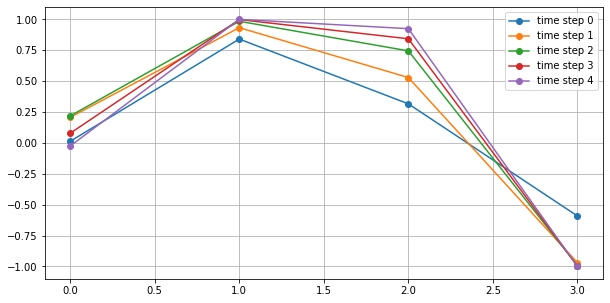

In [27]:
x_seq=tf.convert_to_tensor(
    [[1.*(i+1)]*inputs for i in range(m)],
    dtype=tf.float32)
compare_calc(rnn_layer74,x_seq)

In [28]:
model=tf.keras.Sequential(
    name='simple_rnn_structure')
model.add(tkl.Embedding(1000,32))
model.add(
    tkl.SimpleRNN(32,return_sequences=True))
model.add(tkl.SimpleRNN(32))
model.add(tkl.Dense(1))
model.summary()

Model: "simple_rnn_structure"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 36,193
Trainable params: 36,193
Non-trainable params: 0
_________________________________________________________________


In [29]:
model=tf.keras.Sequential(
    name='lstm_structure')
model.add(tkl.Embedding(10000,32))
model.add(
    tkl.LSTM(32,return_sequences=True))
model.add(tkl.LSTM(32))
model.add(tkl.Dense(1))
model.summary()

Model: "lstm_structure"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 336,673
Trainable params: 336,673
Non-trainable params: 0
_________________________________________________________________


In [30]:
model=tf.keras.Sequential(
    name='gru_structure')
model.add(tkl.Embedding(10000,32))
model.add(
    tkl.GRU(32,return_sequences=True))
model.add(tkl.GRU(32))
model.add(tkl.Dense(1))
model.summary()

Model: "gru_structure"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
gru (GRU)                    (None, None, 32)          6336      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 332,705
Trainable params: 332,705
Non-trainable params: 0
_________________________________________________________________


In [31]:
dhtml('Predicting Sentiments')

In [32]:
dhtml(' '.join(
    [list(token_counts)[i]
     for i in range(32)]),c2,f2,fs2)

In [33]:
embedding_dim=32
vocabulary_size=len(token_counts)+2
model=tf.keras.Sequential(
    name='bi_lstm_model')
model.add(tkl.Embedding(
    input_dim=vocabulary_size,
    output_dim=embedding_dim,
    name='embedding_layer'))
model.add(tkl.Bidirectional(
    tkl.LSTM(64,name='lstm_layer'),
    name='bidirect_lstm_layer'))
model.add(tkl.Dense(64,activation='relu',
                    name='dense_64'))
model.add(tkl.Dense(1,activation='sigmoid',
                    name='out'))
optimizer=tf.keras.optimizers.Adam(1e-3)
loss_fun=tf.keras.losses\
.BinaryCrossentropy(from_logits=False)
model.compile(
    optimizer=optimizer,loss=loss_fun,
    metrics=['accuracy'])

In [34]:
history=model.fit(
    train_data,epochs=10,
    validation_data=valid_data)

Epoch 1/10
932/932 [==============================] - 73s 78ms/step - loss: 0.5212 - accuracy: 0.7376 - val_loss: 0.3787 - val_accuracy: 0.8396
Epoch 2/10
932/932 [==============================] - 72s 77ms/step - loss: 0.4126 - accuracy: 0.8228 - val_loss: 0.4771 - val_accuracy: 0.7883
Epoch 3/10
932/932 [==============================] - 73s 78ms/step - loss: 0.3523 - accuracy: 0.8622 - val_loss: 0.3593 - val_accuracy: 0.8549
Epoch 4/10
932/932 [==============================] - 73s 79ms/step - loss: 0.2892 - accuracy: 0.8899 - val_loss: 0.3365 - val_accuracy: 0.8648
Epoch 5/10
932/932 [==============================] - 73s 78ms/step - loss: 0.2296 - accuracy: 0.9176 - val_loss: 0.3397 - val_accuracy: 0.8721
Epoch 6/10
932/932 [==============================] - 74s 79ms/step - loss: 0.1915 - accuracy: 0.9347 - val_loss: 0.3597 - val_accuracy: 0.8741
Epoch 7/10
932/932 [==============================] - 74s 79ms/step - loss: 0.1871 - accuracy: 0.9385 - val_loss: 0.3734 - val_accuracy:

In [35]:
model.evaluate(test_data)

313/313 [==============================] - 12s 38ms/step - loss: 0.3704 - accuracy: 0.8728


[0.37039732933044434, 0.8727999925613403]

In [43]:
dhtml('Functions in Construction Process')

In [44]:
def preprocess_datasets(
    ds_train,ds_valid,ds_test,
    max_seq_len=None,batch_size=32):
    tokenizer=tfds.features.text.Tokenizer()
    token_counts=Counter()
    for ds in [ds_train,ds_valid,ds_test]:
        for example in ds:
            tokens=tokenizer.tokenize(
                example[0].numpy())
            if max_seq_len is not None:
                tokens=tokens[-max_seq_len:]
            token_counts.update(tokens)
    print('vocabulary size: ',len(token_counts))
    encoder=tfds.features.text\
    .TokenTextEncoder(token_counts)
    def encode(text_tensor,label):
        text=text_tensor.numpy()
        encoded_text=encoder.encode(text)
        if max_seq_len is not None:
            encoded_text=encoded_text[-max_seq_len:]
        return encoded_text,label
    def encode_fmap(text,label):
        return tf.py_function(
            encode,inp=[text,label], 
            Tout=(tf.int64,tf.int64))
    train=ds_train.map(encode_fmap)
    valid=ds_valid.map(encode_fmap)
    test=ds_test.map(encode_fmap)
    train_data=train.padded_batch(
        batch_size,padded_shapes=([-1],[]))
    valid_data=valid.padded_batch(
        batch_size,padded_shapes=([-1],[]))
    test_data=test.padded_batch(
        batch_size,padded_shapes=([-1],[]))
    return (train_data,valid_data,test_data,
            len(token_counts)) 

In [45]:
def build_rnn_model(
    embedding_dim,vocabulary_size,
    recurrent_type='SimpleRNN',
    n_rnn_units=64,n_rnn_layers=1,
    bidirect=True):
    tf.random.set_seed(123)
    model=tf.keras.Sequential()
    model.add(tkl.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        name='embedding_layer'))
    for i in range(n_rnn_layers):
        return_sequences=(i<n_rnn_layers-1)    
        if recurrent_type=='SimpleRNN':
            recurrent_layer=tkl.SimpleRNN(
                units=n_rnn_units, 
                return_sequences=return_sequences,
                name='simple_rnn_layer{}'.format(i))
        elif recurrent_type=='LSTM':
            recurrent_layer=tkl.LSTM(
                units=n_rnn_units, 
                return_sequences=return_sequences,
                name='lstm_layer{}'.format(i))
        elif recurrent_type=='GRU':
            recurrent_layer=tkl.GRU(
                units=n_rnn_units, 
                return_seq=return_sequences,
                name='gru_layer{}'.format(i))     
        if bidirect:
            recurrent_layer=tkl.Bidirectional(
                recurrent_layer,
                name='bidirect_'+recurrent_layer.name)       
        model.add(recurrent_layer)
    model.add(tkl.Dense(64,activation='relu'))
    model.add(tkl.Dense(1,activation='sigmoid'))
    return model

In [46]:
batch_size=32
max_seq_len=100
train_data,valid_data,test_data,n=\
preprocess_datasets(
    ds_train,ds_valid,ds_test,
    max_seq_len=max_seq_len,
    batch_size=batch_size)

vocabulary size:  9807


In [47]:
vocabulary_size=n+2
embedding_dim=32
rnn_model=build_rnn_model(
    embedding_dim,vocabulary_size,
    recurrent_type='SimpleRNN', 
    n_rnn_units=64,n_rnn_layers=3,
    bidirect=True)
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, None, 32)          313888    
_________________________________________________________________
bidirect_simple_rnn_layer0 ( (None, None, 128)         12416     
_________________________________________________________________
bidirect_simple_rnn_layer1 ( (None, None, 128)         24704     
_________________________________________________________________
bidirect_simple_rnn_layer2 ( (None, 128)               24704     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 384,033
Trainable params: 384,033
Non-trainable params: 0
________________________________________________

In [48]:
optimizer=tf.keras.optimizers.Adam(1e-3)
loss_fun=tf.keras.losses\
.BinaryCrossentropy(from_logits=False)
rnn_model.compile(
    optimizer=optimizer,loss=loss_fun,
    metrics=['accuracy'])
history=rnn_model.fit(
    train_data,epochs=10,
    validation_data=valid_data)

Epoch 1/10
932/932 [==============================] - 353s 378ms/step - loss: 0.6760 - accuracy: 0.5761 - val_loss: 0.6311 - val_accuracy: 0.6340
Epoch 2/10
932/932 [==============================] - 348s 373ms/step - loss: 0.5803 - accuracy: 0.6920 - val_loss: 0.5251 - val_accuracy: 0.7508
Epoch 3/10
932/932 [==============================] - 354s 380ms/step - loss: 0.4898 - accuracy: 0.7644 - val_loss: 0.6148 - val_accuracy: 0.6868
Epoch 4/10
932/932 [==============================] - 352s 377ms/step - loss: 0.4459 - accuracy: 0.7884 - val_loss: 0.5714 - val_accuracy: 0.7129
Epoch 5/10
932/932 [==============================] - 357s 383ms/step - loss: 0.4162 - accuracy: 0.8109 - val_loss: 0.6090 - val_accuracy: 0.7299
Epoch 6/10
932/932 [==============================] - 357s 383ms/step - loss: 0.3423 - accuracy: 0.8564 - val_loss: 0.5283 - val_accuracy: 0.7873
Epoch 7/10
932/932 [==============================] - 359s 385ms/step - loss: 0.4049 - accuracy: 0.8109 - val_loss: 0.6510 -

In [49]:
rnn_model.evaluate(test_data)

313/313 [==============================] - 17s 53ms/step - loss: 0.7660 - accuracy: 0.6883


[0.7660064101219177, 0.6883000135421753]